In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing, model_selection
import lightgbm as lgb

In [2]:
# read the data
df_test = pd.read_csv('../data/test_mSzZ8RL_DKa2Eez_7CURkcw.csv')
df_train = pd.read_csv('../data/train_s3TEQDk_IyaGz9Y_nvfXhoC.csv')

In [3]:
# missing values
df_train['Credit_Product'].fillna('no info', inplace=True)
df_test['Credit_Product'].fillna('no info', inplace=True)

In [4]:
# Label encode the categorical variables
for col in df_train.columns:
    if df_train[col].dtype==object and col not in ['ID','Is_Lead']:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
        df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
        df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))

In [5]:
df_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,0,73,18,1,2,43,0,1045696,0,0
1,IDD62UNG,0,30,27,2,0,32,0,581988,0,0
2,HD3DSEMC,0,56,18,3,2,26,0,1484315,1,0
3,BF3NC7KV,1,34,20,2,0,19,0,470454,0,0
4,TEASRWXV,0,30,32,2,0,33,0,886787,0,0


In [6]:
X = df_train.drop(['ID','Is_Lead'], axis=1)
y = df_train['Is_Lead']

In [7]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators' : 1000
}


def cv_classif(X,y,test):
    
    # cross validation
    i = 1
    scores_val = []
    scores_train = []
    yhat_test = 0
    
    #kf = model_selection.StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
    kf = model_selection.KFold(n_splits=5,random_state=100,shuffle=True)
    
    for train_index,val_index in kf.split(X,y):
        X_train,X_val = X.loc[train_index],X.loc[val_index]
        y_train,y_val = y[train_index],y[val_index]
        
        # model
        clf = lgb.LGBMClassifier(**lgb_params,early_stopping_round=100,random_state=100) #, verbose_eval=50)
        
        # Fit the model
        clf.fit(X_train,y_train,eval_set=[(X_val,y_val),(X_train,y_train)],verbose=50)
                
        # Get 'AUC Score'
        train_auc = metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
        val_auc = metrics.roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

        # Predict on test
        yhat_test = clf.predict_proba(test.drop(['ID'], axis=1))[:, 1]
        scores_val.append(val_auc)
        scores_train.append(train_auc)
        yhat_test += yhat_test 
        i+=1
    yhat_test /= 5 
    return scores_val,scores_train,yhat_test,clf

In [8]:
X = df_train.drop(['ID','Is_Lead'], axis=1)
y = df_train['Is_Lead']

In [9]:
scores_val,scores_train,yhat_test,clf = cv_classif(X,y,df_test)

c:\program files\python38\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.877494	valid_0's auc: 0.872885
[100]	training's auc: 0.882447	valid_0's auc: 0.873179
[150]	training's auc: 0.885935	valid_0's auc: 0.873105
[200]	training's auc: 0.88874	valid_0's auc: 0.872952
Early stopping, best iteration is:
[106]	training's auc: 0.883059	valid_0's auc: 0.873336


c:\program files\python38\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.877085	valid_0's auc: 0.873257
[100]	training's auc: 0.881985	valid_0's auc: 0.873284
[150]	training's auc: 0.885795	valid_0's auc: 0.87274
Early stopping, best iteration is:
[78]	training's auc: 0.879749	valid_0's auc: 0.87337


c:\program files\python38\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.876282	valid_0's auc: 0.876567
[100]	training's auc: 0.880809	valid_0's auc: 0.876585
[150]	training's auc: 0.884858	valid_0's auc: 0.87653
Early stopping, best iteration is:
[68]	training's auc: 0.877918	valid_0's auc: 0.876709


c:\program files\python38\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.877199	valid_0's auc: 0.872692
[100]	training's auc: 0.882173	valid_0's auc: 0.872796
[150]	training's auc: 0.885359	valid_0's auc: 0.872376
Early stopping, best iteration is:
[90]	training's auc: 0.881266	valid_0's auc: 0.873073


c:\program files\python38\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.876899	valid_0's auc: 0.874166
[100]	training's auc: 0.882431	valid_0's auc: 0.874001
[150]	training's auc: 0.885471	valid_0's auc: 0.873964
Early stopping, best iteration is:
[50]	training's auc: 0.876899	valid_0's auc: 0.874166


In [10]:
print('Mean Validation score:',np.mean(scores_val))
print('Mean train score     :',np.mean(scores_train))

Mean Validation score: 0.8741308045618735
Mean train score     : 0.8797778576940131


In [11]:
scores_val

[0.8733361471868611,
 0.8733704313458708,
 0.8767085768138679,
 0.8730725386840554,
 0.8741663287787125]

In [12]:
scores_train

[0.8830589938083464,
 0.8797485680469345,
 0.8779175901441145,
 0.8812655591071208,
 0.8768985773635488]

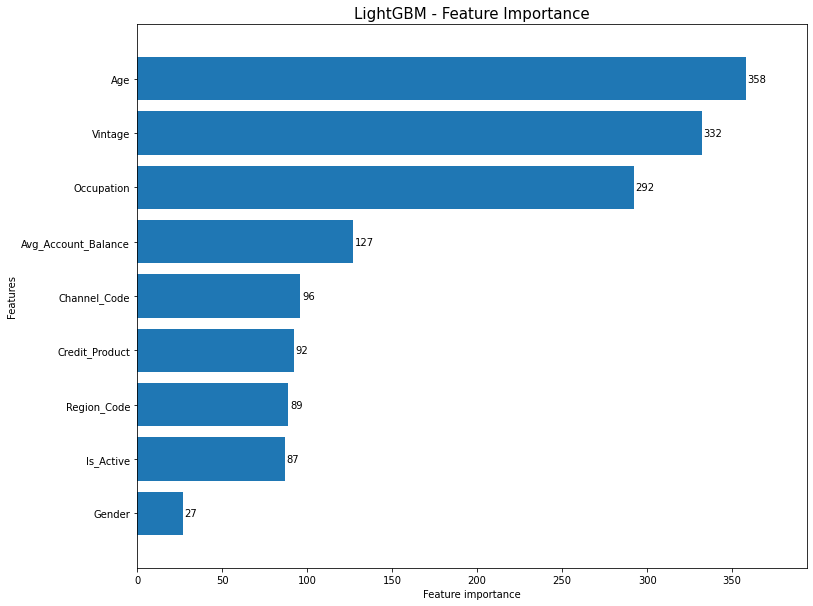

In [13]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(clf, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

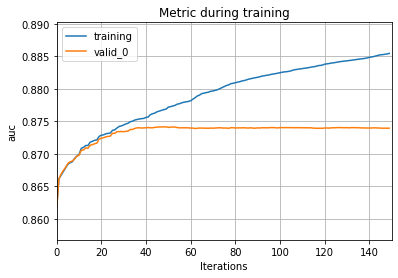

In [14]:
lgb.plot_metric(clf)

In [15]:
sub_df = pd.DataFrame(df_test['ID'])
sub_df['Is_Lead'] = yhat_test
sub_df.to_csv("../submission/sub_lgb_20211107.csv", index=False)